In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

# Path to data
DATA_PATH = Path('../data')

In [2]:
def load_data():
    files = {
        'deployments': 'deployments.csv',
        'inventory': 'inventory_snapshots.csv',
        'po': 'purchase_orders.csv',
        'rma': 'rma_returns.csv',
        'shipments': 'shipments.csv',
        'sites': 'sites.csv',
        'skus': 'skus.csv',
        'suppliers': 'suppliers.csv',
        'transit': 'transit_events.csv'
    }
    
    dfs = {}
    for name, file in files.items():
        dfs[name] = pd.read_csv(DATA_PATH / file)
        
    return dfs

dfs = load_data()

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\deployments.csv'

In [ ]:
# Data Cleaning & Preprocessing
date_cols = {
    'deployments': ['planned_date', 'actual_date'],
    'inventory': ['snapshot_date'],
    'po': ['order_date', 'promised_date'],
    'rma': ['rma_date'],
    'shipments': ['ship_date', 'eta_date'],
    'transit': ['event_ts']
}

for name, cols in date_cols.items():
    for col in cols:
        if col in dfs[name].columns:
            dfs[name][col] = pd.to_datetime(dfs[name][col], errors='coerce')

print("Data loaded and dates parsed.")

Data loaded and dates parsed.


## 1. Supply Chain Performance

We analyze the time it takes for goods to move from order to delivery.

*   **Supplier Lead Time**: Time from Order to Shipment.
*   **Transit Time**: Time from Shipment to Delivery.
*   **Total Lead Time**: Time from Order to Delivery.

In [ ]:
# Merge PO, Shipments, and Transit to get full picture
po_ship = pd.merge(dfs['po'], dfs['shipments'], on='po_id', how='left')

# Get actual delivery date from transit events (last 'Delivered' event)
delivered_events = dfs['transit'][dfs['transit']['event_status'] == 'Delivered'].sort_values('event_ts').drop_duplicates('shipment_id', keep='last')
po_ship = pd.merge(po_ship, delivered_events[['shipment_id', 'event_ts']], on='shipment_id', how='left')
po_ship.rename(columns={'event_ts': 'actual_delivery_date'}, inplace=True)

# Calculate Lead Times
po_ship['actual_supplier_lead_time'] = (po_ship['ship_date'] - po_ship['order_date']).dt.days
po_ship['actual_transit_time'] = (po_ship['actual_delivery_date'] - po_ship['ship_date']).dt.days
po_ship['total_lead_time'] = (po_ship['actual_delivery_date'] - po_ship['order_date']).dt.days

# Data Quality Check: Order Date > Ship Date
invalid_dates = po_ship[po_ship['order_date'] > po_ship['ship_date']]
print(f"Data Quality Warning: {len(invalid_dates)} records have Order Date > Ship Date.")

# Filter out invalid lead times for analysis
valid_lead_times = po_ship[po_ship['total_lead_time'] > 0]

print(f"Average Total Lead Time: {valid_lead_times['total_lead_time'].mean():.1f} days")
print(f"Average Transit Time: {valid_lead_times['actual_transit_time'].mean():.1f} days")

Data Quality Warning: 108981 records have Order Date > Ship Date.
Average Total Lead Time: 352.8 days
Average Transit Time: 186.3 days


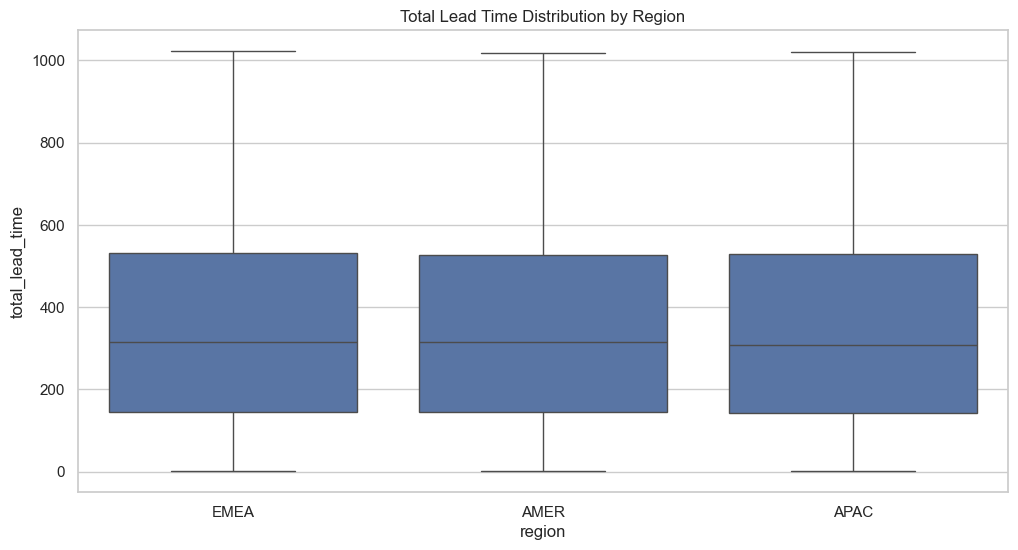

In [ ]:
# Visualization: Lead Time by Region
plt.figure(figsize=(12, 6))
sns.boxplot(data=valid_lead_times, x='region', y='total_lead_time')
plt.title('Total Lead Time Distribution by Region')
plt.show()

### Supplier Reliability
Measuring On-Time Performance (OTP) against the `promised_date`.

In [ ]:
po_ship['delivery_delay'] = (po_ship['actual_delivery_date'] - po_ship['promised_date']).dt.days
po_ship['on_time'] = po_ship['delivery_delay'] <= 0

supplier_perf = po_ship.groupby('supplier_id').agg({
    'on_time': 'mean',
    'delivery_delay': 'mean',
    'po_id': 'count'
}).reset_index()

supplier_perf = pd.merge(supplier_perf, dfs['suppliers'], on='supplier_id')

print("Top 5 Suppliers by On-Time Performance (min 5 orders):")
display(supplier_perf[supplier_perf['po_id'] >= 5].sort_values('on_time', ascending=False).head())

print("\nBottom 5 Suppliers by On-Time Performance (min 5 orders):")
display(supplier_perf[supplier_perf['po_id'] >= 5].sort_values('on_time', ascending=True).head())

Top 5 Suppliers by On-Time Performance (min 5 orders):


,supplier_id,on_time,delivery_delay,po_id,region,country,primary_vendor,on_time_performance,iso_certified
164,S-0165,0.129474,-59.996656,1313,AMER,USA,Juniper,0.794,True
107,S-0108,0.128384,-78.610345,1293,AMER,Mexico,NEC,0.896,True
171,S-0172,0.128226,-53.902174,1201,EMEA,France,Nokia,0.812,False
73,S-0074,0.127724,-12.990826,1331,APAC,China,Ericsson,0.948,True
146,S-0147,0.126935,-35.351536,1292,EMEA,Germany,Cisco,0.854,False



Bottom 5 Suppliers by On-Time Performance (min 5 orders):


,supplier_id,on_time,delivery_delay,po_id,region,country,primary_vendor,on_time_performance,iso_certified
109,S-0110,0.088120,59.166667,1271,EMEA,Austria,Cisco,0.927,True
184,S-0185,0.089213,63.259928,1233,APAC,Australia,Cisco,0.943,True
46,S-0047,0.089368,48.904762,1298,EMEA,Netherlands,Nokia,0.905,False
179,S-0180,0.089701,58.336066,1204,AMER,USA,NEC,0.854,True
19,S-0020,0.092784,10.034884,1261,APAC,Vietnam,Huawei,0.943,True


In [ ]:
summary_metrics = {
    "po_total": len(dfs["po"]),
    "ship_total": len(dfs["shipments"]),
    "invalid_order_vs_ship": len(invalid_dates),
    "invalid_pct": len(invalid_dates) / len(dfs["po"]) * 100,
    "otp_overall": po_ship["on_time"].mean() * 100,
    "median_total_lead": valid_lead_times["total_lead_time"].median(),
    "median_transit": valid_lead_times["actual_transit_time"].median(),
    "mean_transit": valid_lead_times["actual_transit_time"].mean(),
}

summary_metrics

{'po_total': 150000,
 'ship_total': 217500,
 'invalid_order_vs_ship': 108981,
 'invalid_pct': 72.654,
 'otp_overall': np.float64(10.991504782272916),
 'median_total_lead': 313.0,
 'median_transit': 187.0,
 'mean_transit': np.float64(186.31522636576304)}

## 2. Inventory Health

Analyzing stock levels and value over time.

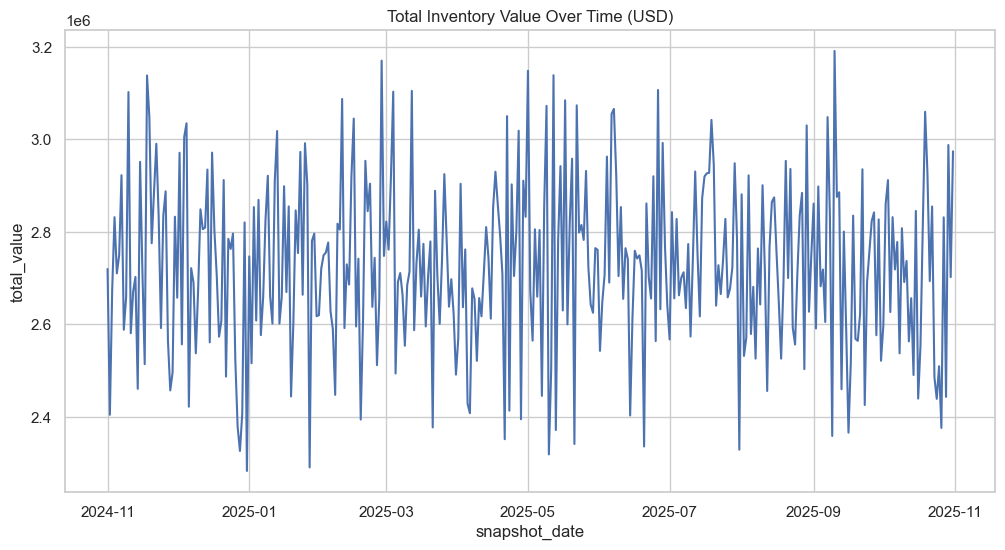

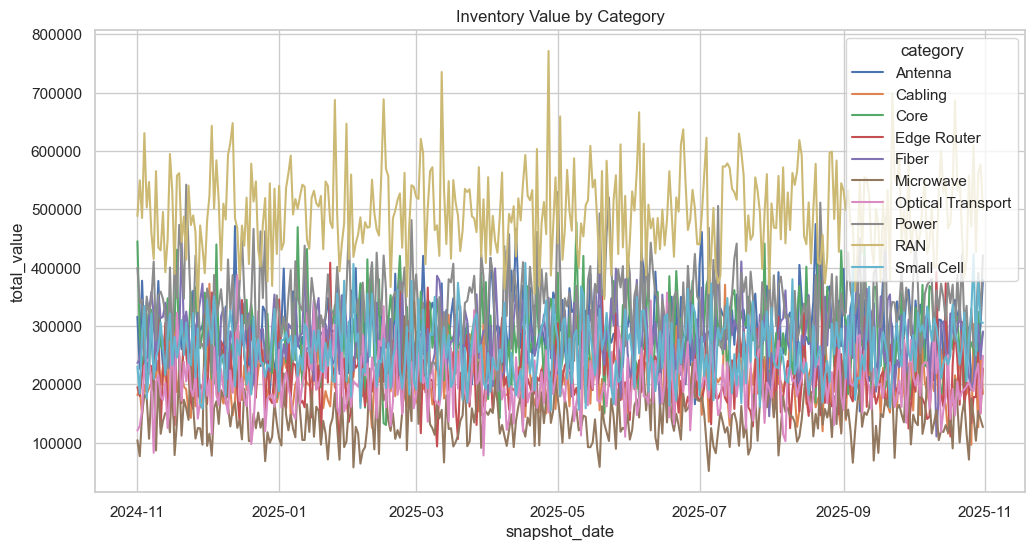

In [ ]:
inv_sku = pd.merge(dfs['inventory'], dfs['skus'], on='sku_id')
inv_sku['total_value'] = inv_sku['on_hand_qty'] * inv_sku['std_cost_usd']

daily_inv = inv_sku.groupby('snapshot_date')['total_value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_inv, x='snapshot_date', y='total_value')
plt.title('Total Inventory Value Over Time (USD)')
plt.show()

# Breakdown by Category
cat_inv = inv_sku.groupby(['snapshot_date', 'category'])['total_value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cat_inv, x='snapshot_date', y='total_value', hue='category')
plt.title('Inventory Value by Category')
plt.show()

In [ ]:
inv_summary = {
    "snapshots": inv_sku["snapshot_date"].nunique(),
    "sites_tracked": inv_sku["site_id"].nunique(),
    "skus_tracked": inv_sku["sku_id"].nunique(),
    "avg_daily_value": daily_inv["total_value"].mean(),
    "p95_daily_value": daily_inv["total_value"].quantile(0.95),
}

category_pivot = (
    inv_sku.groupby("category")["total_value"].sum()
    .sort_values(ascending=False)
    .reset_index()
)
category_pivot

,category,total_value
0,RAN,1.813082e+08
1,Power,1.237819e+08
2,Antenna,1.076164e+08
3,Core,1.033898e+08
4,Fiber,1.018040e+08
5,Small Cell,9.463023e+07
6,Edge Router,7.861124e+07
7,Cabling,7.650322e+07
8,Optical Transport,7.484827e+07
9,Microwave,5.292453e+07


In [ ]:
inv_summary

{'snapshots': 365,
 'sites_tracked': 2000,
 'skus_tracked': 5000,
 'avg_daily_value': np.float64(2727171.7936438355),
 'p95_daily_value': np.float64(3046915.042)}

In [ ]:
category_pivot["total_value"].sum()

np.float64(995417704.68)

## 3. Quality Control (RMA)

Analyzing return rates and reasons.

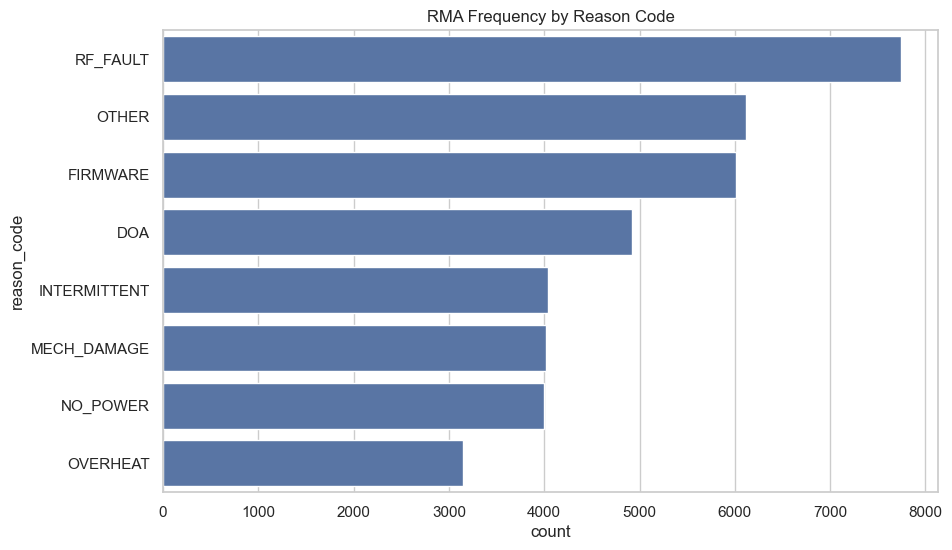

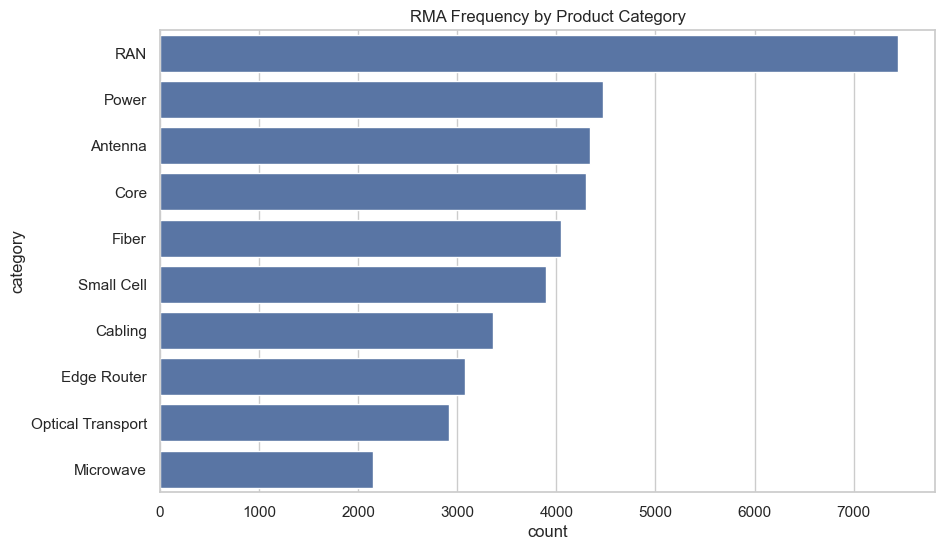

In [ ]:
rma_sku = pd.merge(dfs['rma'], dfs['skus'], on='sku_id')

# RMA Reasons
plt.figure(figsize=(10, 6))
sns.countplot(data=rma_sku, y='reason_code', order=rma_sku['reason_code'].value_counts().index)
plt.title('RMA Frequency by Reason Code')
plt.show()

# RMA by Category
plt.figure(figsize=(10, 6))
sns.countplot(data=rma_sku, y='category', order=rma_sku['category'].value_counts().index)
plt.title('RMA Frequency by Product Category')
plt.show()

In [ ]:
rma_summary = (
    rma_sku.assign(is_warranty=rma_sku["under_warranty"].astype(bool))
    .agg({
        "rma_id": "count",
        "is_warranty": "mean"
    })
)

rma_by_region = (
    rma_sku.merge(dfs["sites"], on="site_id", how="left")
    .groupby("region")["rma_id"].count()
    .sort_values(ascending=False)
)

rma_summary, rma_by_region.head()


(rma_id         40000.00000
 is_warranty        0.70375
 dtype: float64,
 region
 EMEA    22874
 APAC     9690
 AMER     7436
 Name: rma_id, dtype: int64)

In [ ]:
reason_counts = rma_sku["reason_code"].value_counts()
category_counts = rma_sku["category"].value_counts()
reason_counts.head(), category_counts.head()

(reason_code
 RF_FAULT        7746
 OTHER           6119
 FIRMWARE        6011
 DOA             4925
 INTERMITTENT    4038
 Name: count, dtype: int64,
 category
 RAN        7450
 Power      4466
 Antenna    4343
 Core       4298
 Fiber      4049
 Name: count, dtype: int64)

## 4. Project Execution (Deployments)

Analyzing schedule adherence for deployments.

Average Deployment Delay: 10.3 days
Percentage of On-Time Deployments: 27.7%


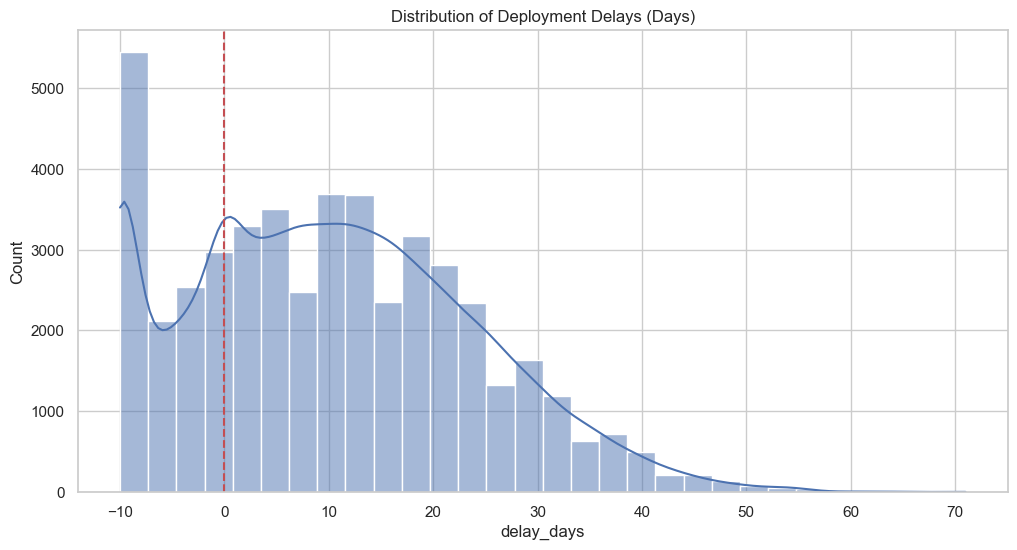

In [ ]:
deploy = dfs['deployments'].copy()
deploy = deploy.dropna(subset=['actual_date'])
deploy['delay_days'] = (deploy['actual_date'] - deploy['planned_date']).dt.days

print(f"Average Deployment Delay: {deploy['delay_days'].mean():.1f} days")
print(f"Percentage of On-Time Deployments: {(deploy['delay_days'] <= 0).mean() * 100:.1f}%")

plt.figure(figsize=(12, 6))
sns.histplot(data=deploy, x='delay_days', bins=30, kde=True)
plt.title('Distribution of Deployment Delays (Days)')
plt.axvline(0, color='r', linestyle='--')
plt.show()

In [ ]:
deploy_total = len(dfs["deployments"])
deploy_with_actual = deploy_total - dfs["deployments"]["actual_date"].isna().sum()
deploy_missing_actual_pct = (deploy_total - deploy_with_actual) / deploy_total * 100

deploy_total, deploy_with_actual, deploy_missing_actual_pct

(80000, np.int64(47107), np.float64(41.11625))